In [1]:
import time
start_time = time.time()
from pathlib import Path
import numpy as np
import pandas as pd
import json
import cmasher as cmr
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import corner

#import turbustat.statistics as tss
#import turbustat.simulator
#from turbustat.simulator import make_ppv
#from spectral_cube import SpectralCube  

#from astropy.io import fits
#from astropy.utils.misc import JsonCustomEncoder
#import astropy.units as u
#from astropy.convolution import Gaussian2DKernel, convolve_fft

#import lmfit

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc
import bplot

sns.set_color_codes()
sns.set_context("talk")

In [2]:
def ratio_empirical(rad, s0, a=1.0):
    """
    Simple tanh law in semi-log space to fit the seeing

    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    #x = np.log(rad / (2 * s0))
    #y = np.tanh(a * x)
    #return 0.5 * (1.0 + y)

    x = ((2 * s0) / rad)**(2*a)
    return  (1.0 + x)**-1


def bfac(x):
    """
    Across-the board reduction in B(r) for x = s0 / r0

    Where s0 is RMS seeing width and r0 is correlation length
    """
    #return 1 / (1 + 4 * x ** 2)
    return np.exp(-x)


def seeing_empirical(r, s0, r0, a):
    return bfac(s0 / r0) * ratio_empirical(r, s0, a)

In [3]:
r_model = np.linspace(0.01,200,1000)


In [4]:
widths = [1, 2, 4, 8, 16, 32]
s0 = [1 ,2 , 4, 8, 16, 32 ]


In [5]:
#[rat,r,rat0,apparent_r0,true_r0]
a = json.load(open("ratios_seeing.json"))

In [13]:
a['1']

[[0.23035460473897582,
  0.3043575538962311,
  0.408063673221343,
  0.4834488047805677,
  0.5200867038310473,
  0.5585187229639924,
  0.5929348018729956,
  0.6296011702642389,
  0.6560232631958935,
  0.6794827161430298,
  0.7054399419352583,
  0.7269637697322258,
  0.7433787339274155,
  0.7611823188121419,
  0.7778235540489079,
  0.7924792599794942,
  0.8042460207472794,
  0.8159324561461455,
  0.8260418614354601,
  0.8350298959786476,
  0.8431795982757443,
  0.8506136849106372,
  0.8567805305496711,
  0.8621975758890826,
  0.867140203432944,
  0.8714743475226081,
  0.8752607300991119,
  0.8784389110563018,
  0.8808952492792952,
  0.8825008021389428,
  0.8834616539072008,
  0.8842169449550975,
  0.8848387414064619,
  0.8854423848446842,
  0.8864533053384247,
  0.8879026257077408,
  0.8906795843839257,
  0.8946258498094336,
  0.8979940607564437,
  0.89689913056244,
  0.8934103272520797,
  0.8909930286277019,
  0.8899323085650669,
  0.8976859312580576,
  0.9016464387693711],
 [1.0,
  1.4

In [6]:
r = np.array(a['1'][1])

In [7]:
r

array([  1.        ,   1.41253754,   1.99526231,   2.81838293,
         3.16227766,   3.54813389,   3.98107171,   4.46683592,
         5.01187234,   5.62341325,   6.30957344,   7.07945784,
         7.94328235,   8.91250938,  10.        ,  11.22018454,
        12.58925412,  14.12537545,  15.84893192,  17.7827941 ,
        19.95262315,  22.38721139,  25.11886432,  28.18382931,
        31.6227766 ,  35.48133892,  39.81071706,  44.66835922,
        50.11872336,  56.23413252,  63.09573445,  70.79457844,
        79.43282347,  89.12509381, 100.        , 112.20184543,
       125.89254118, 141.25375446, 158.48931925, 177.827941  ,
       199.5262315 , 223.87211386, 251.18864315, 281.83829313,
       316.22776602])

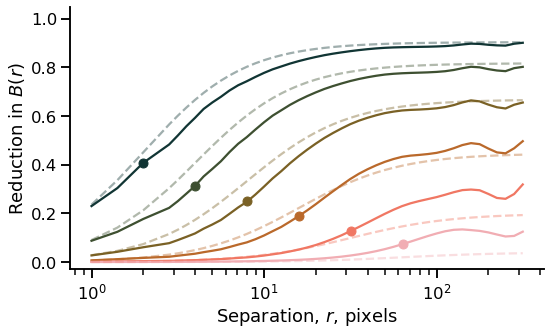

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

for i,c in zip(range(6), colors):
    ax.plot(r , a[str(widths[i])][0], color=c)
    ax.plot(2 * widths[i], a[str(widths[i])][2], marker="o",  color=c)
  
    
for i,c in zip(range(6), colors):
    ax.plot(r, seeing_empirical(np.array(r), widths[i], a[str(widths[i])][4], 0.75), color=c, linestyle="dashed", alpha = 0.4)


    
ax.set(
    xscale="log",
    yscale="linear",
    ylim=[-0.03,1.05],
    xlabel="Separation, $r$, pixels",
    ylabel="Reduction in $B(r)$",
)
sns.despine()
fig.tight_layout()

In [9]:
 seeing_empirical(1,1, 32, 1)

0.19384664689526884

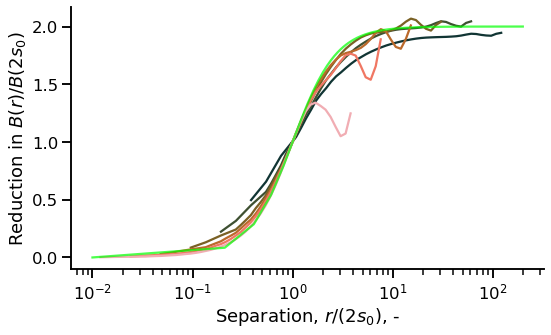

In [33]:
R_NORM = 2.6

fig, ax = plt.subplots(figsize=(8, 5))

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

b_norms = []


for i,c in zip(range(6), colors):
    rat0 = np.interp(R_NORM * widths[i], r, np.array(a[str(widths[i])][0]))
    b_norms.append(rat0)
    ax.plot(r/(R_NORM * widths[i]) , np.array(a[str(widths[i])][0])/rat0, color=c)
    
    #ax.plot(2 * widths[i]/(2 * widths[i]), a[str(widths[i])][2]/np.array(a[str(widths[i])][2]), marker="o",  color=c)
  
    
ax.plot(r_model , 2*(1 + (1/r_model)**2 )**-1, color='lime', linestyle="-", alpha = 0.7)

  
ax.set(
    xscale="log",
    yscale="linear",
#    ylim=[-0.03,1.05],
    xlabel="Separation, $r / (2 s_0)$, -",
    ylabel="Reduction in $B(r) / B(2 s_0)$",
)
sns.despine()
fig.tight_layout()

[(0.0, 0.4816134816862196), Text(0, 0.5, 'max B'), Text(0.5, 0, 's0')]

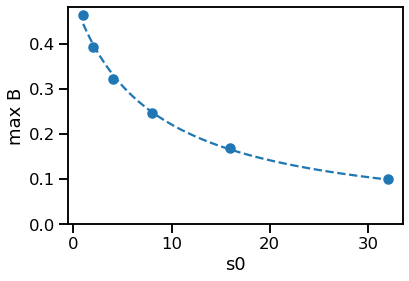

In [60]:
fig, ax = plt.subplots()

wgrid = np.logspace(0.0, 1.5, 200)
plt.scatter(widths,b_norms)
ax.plot(wgrid, 0.5*(1 + 1.25 * wgrid / 9.9)**-1.0, linestyle="dashed")

ax.set(
    xlabel="s0",
    ylabel="max B",
    ylim=[0.0, None],
 #   xscale="log",
)

In [11]:
xxx

NameError: name 'xxx' is not defined

In [ ]:



fig, ax = plt.subplots(figsize=(8, 5))

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

for i,c in zip(range(6), colors):
    ax.plot(2 * widths[i]/(2 * widths[i]), a[str(widths[i])][2]/np.array(a[str(widths[i])][0]).max(), marker="o",  color=c)
    ax.plot(r/(2 * widths[i]) , np.array(a[str(widths[i])][0])/np.array(a[str(widths[i])][0]).max(), color=c, linestyle="-")
    

ax.plot(r_model , seeing_empirical(r_model, 1, 32, 0.75), color='lime', linestyle="-", alpha = 0.7)


ax.set(
    xscale="log",
    yscale="linear",
#    ylim=[-0.03,1.05],
    xlabel="Separation, $r / (2_s0)$, -",
    ylabel="Reduction in $B(r)/ \text{max} B(r)$",
)
sns.despine()
fig.tight_layout()

## 2: Confidence intervals of individual ratios (three parameters)

$   S(r) = \dfrac{
    e^{-(\frac{s_0}{r_0}c)^b}
  }{
    1+(2s_0 / r)^{2a}
  } $

In [ ]:
def ratio_empirical(rad, s0, a):
    """
    Simple tanh law in semi-log space to fit the seeing

    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    #x = np.log(rad / (2 * s0))
    #y = np.tanh(a * x)
    #return 0.5 * (1.0 + y)

    x = ((2 * s0) / rad)**(2*a)
    return  (1.0 + x)**-1


def bfac(x, b):
    """
    Across-the board reduction in B(r) for x = s0 / r0

    Where s0 is RMS seeing width and r0 is correlation length
    """
    #return 1 / (1 + 4 * x ** 2)
    return np.exp(-x**(b))


def seeing_empirical(r, s0, r0, a, b, c ):
    return bfac((s0*c)/ r0, b) * ratio_empirical(r, s0, a)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

for i,c in zip(range(6), colors):
    ax.plot(r , a[str(widths[i])][0], color=c)
     
for i,c in zip(range(6), colors):
    ax.plot(r, seeing_empirical(np.array(r), widths[i], a[str(widths[i])][4], 0.76, 0.8, 0.85), color=c, linestyle="dashed", alpha = 0.7)

ax.set(
    xscale="log",
    yscale="linear",
    ylim=[-0.03,1.05],
    xlabel="Separation, $r$, pixels",
    ylabel="Reduction in $B(r)$",
)
sns.despine()
fig.tight_layout()

In [ ]:
xxx

## 1: Confidence intervals of individual ratios (two parameters)

In [ ]:
def ratio_empirical(rad, s0, a=1.0):
    """
    Simple tanh law in semi-log space to fit the seeing

    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    #x = np.log(rad / (2 * s0))
    #y = np.tanh(a * x)
    #return 0.5 * (1.0 + y)

    x = ((2 * s0) / rad)**(2*a)
    return  (1.0 + x)**-1


def bfac(x, n = 1.0):
    """
    Across-the board reduction in B(r) for x = s0 / r0

    Where s0 is RMS seeing width and r0 is correlation length
    """
    #return 1 / (1 + 4 * x ** 2)
    return np.exp(-x*n)


def seeing_empirical(r, s0, r0, a, n):
    return bfac(s0 / r0, n) * ratio_empirical(r, s0, a)

In [ ]:
b = [0.66, 0.77, 0.83, 0.85, 0.85, 0.84  ]
n = [1.28, 1.40, 1.24, 1.01, 0.80, 0.62 ]

In [ ]:
plt.scatter(b,n, s = np.array(s0)*5)
plt.scatter(np.array(b).mean(), np.array(n).mean())

plt.xlabel('a')
plt.ylabel('n')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

for i,c in zip(range(6), colors):
    ax.plot(r , a[str(widths[i])][0], color=c)
    
for i,c,x,y in zip(range(6), colors, np.array(b), np.array(n)):
    ax.plot(r, seeing_empirical(np.array(r), widths[i], a[str(widths[i])][4], np.array(b).mean(),np.array(n).mean()), color=c, linestyle="dashed")
    
for i,c in zip(range(6), colors):
    ax.plot(r, seeing_empirical(np.array(r), widths[i], a[str(widths[i])][4], np.array(b[i]),  np.array(n[i]) ), color=c, linestyle=":", alpha = 0.7)

ax.set(
    xscale="log",
    yscale="linear",
    ylim=[-0.03,1.05],
    xlabel="Separation, $r$, pixels",
    ylabel="Reduction in $B(r)$",
)
sns.despine()
fig.tight_layout()